In [1]:
import torch
import math

def calculate_indices(si, sj, h, w, new_h, new_w, x_device):
    max_area_coverage = torch.zeros((h, w), device=x_device)
    merge_indices = torch.full((new_h, new_w, 2), -1, dtype=torch.long, device=x_device)
    unmerge_indices = torch.full((h, w, 2), -1, dtype=torch.long, device=x_device)

    for i in range(new_h):
        for j in range(new_w):
            start_i = i * si
            start_j = j * sj
            end_i = start_i + si
            end_j = start_j + sj

            istart = int(math.floor(start_i))
            jstart = int(math.floor(start_j))
            iend = min(int(math.ceil(end_i)), h)
            jend = min(int(math.ceil(end_j)), w)

            weights = []
            indices = []

            for ii in range(istart, iend):
                for jj in range(jstart, jend):
                    top = max(start_i, ii)
                    left = max(start_j, jj)
                    bottom = min(end_i, ii + 1)
                    right = min(end_j, jj + 1)
                    area = max(0, right - left) * max(0, bottom - top)
                    if area > 0:
                        weights.append(area)
                        indices.append((ii, jj))

            if weights:
                max_idx = weights.index(max(weights))
                max_ii, max_jj = indices[max_idx]
                merge_indices[i, j, 0] = max_ii
                merge_indices[i, j, 1] = max_jj
                for weight, (ii, jj) in zip(weights, indices):
                    if weight > max_area_coverage[ii, jj]:
                        max_area_coverage[ii, jj] = weight
                        unmerge_indices[ii, jj, 0] = i
                        unmerge_indices[ii, jj, 1] = j

    return merge_indices, unmerge_indices, max_area_coverage

def calculate_indices_vectorized(si, sj, h, w, new_h, new_w, x_device):
    dtype = torch.float32
    device = torch.device(x_device)

    global_i, global_j = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    start_is = (torch.arange(new_h, device=device) * si).floor()
    start_js = (torch.arange(new_w, device=device) * sj).floor()
    end_is = (start_is + si).clamp(max=h)
    end_js = (start_js + sj).clamp(max=w)

    merge_indices = torch.full((new_h, new_w, 2), -1, dtype=torch.long, device=device)
    unmerge_indices = torch.full((h, w, 2), -1, dtype=torch.long, device=device)
    max_area_coverage = torch.zeros((h, w), device=device)

    for i in range(new_h):
        for j in range(new_w):
            istart = int(start_is[i].floor())
            jstart = int(start_js[j].floor())
            iend = int(end_is[i].clamp(max=h))
            jend = int(end_js[j].clamp(max=w))

            local_is = global_i[istart:iend, jstart:jend]
            local_js = global_j[istart:iend, jstart:jend]
            area = (torch.min(local_is + 1, end_is[i]) - torch.max(local_is, start_is[i])) * \
                   (torch.min(local_js + 1, end_js[j]) - torch.max(local_js, start_js[j]))
            area = area.clamp(min=0)

            max_area, max_pos = torch.max(area.view(-1), dim=0)
            max_ii, max_jj = divmod(max_pos, area.shape[1])
            max_ii += istart
            max_jj += jstart

            merge_indices[i, j, :] = torch.tensor([max_ii, max_jj], dtype=torch.long, device=device)

            mask = area > max_area_coverage[istart:iend, jstart:jend]
            max_area_coverage[istart:iend, jstart:jend] = torch.where(mask, area, max_area_coverage[istart:iend, jstart:jend])
            unmerge_indices[istart:iend, jstart:jend, 0][mask] = i
            unmerge_indices[istart:iend, jstart:jend, 1][mask] = j

    return merge_indices, unmerge_indices, max_area_coverage

# Parameters
si, sj, h, w, new_h, new_w = 2.5, 2.5, 10, 10, 4, 4
x_device = 'cpu'

# Execute functions
original = calculate_indices(si, sj, h, w, new_h, new_w, x_device)
vectorized = calculate_indices_vectorized(si, sj, h, w, new_h, new_w, x_device)

# Compare results
results = {
    "Merge Indices Match": torch.equal(original[0], vectorized[0]),
    "Unmerge Indices Match": torch.equal(original[1], vectorized[1]),
    "Max Area Coverage Match": torch.equal(original[2], vectorized[2])
}

TypeError: unsupported operand type(s) for divmod(): 'Tensor' and 'int'

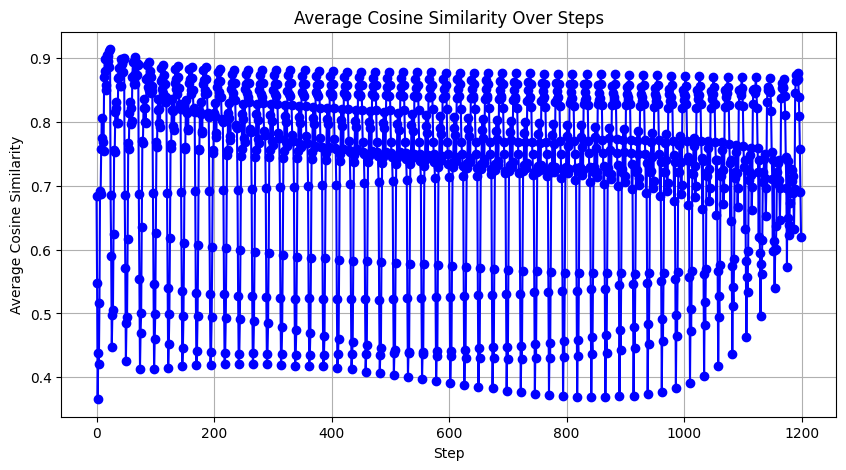

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cosine_similarity_from_file(file_path):
    # 从文件中读取余弦相似度数据
    with open(file_path, 'r') as file:
        similarities = [float(line.strip()) for line in file if line.strip()]

    # 使用numpy生成步骤序列
    steps = np.arange(len(similarities))

    # 创建图表
    plt.figure(figsize=(10, 5))
    plt.plot(steps, similarities, marker='o', linestyle='-', color='b')
    plt.title('Average Cosine Similarity Over Steps')
    plt.xlabel('Step')
    plt.ylabel('Average Cosine Similarity')
    plt.grid(True)
    plt.show()

# 调用函数，指定文本文件的路径
plot_cosine_similarity_from_file("average_cosine_similarity.txt")

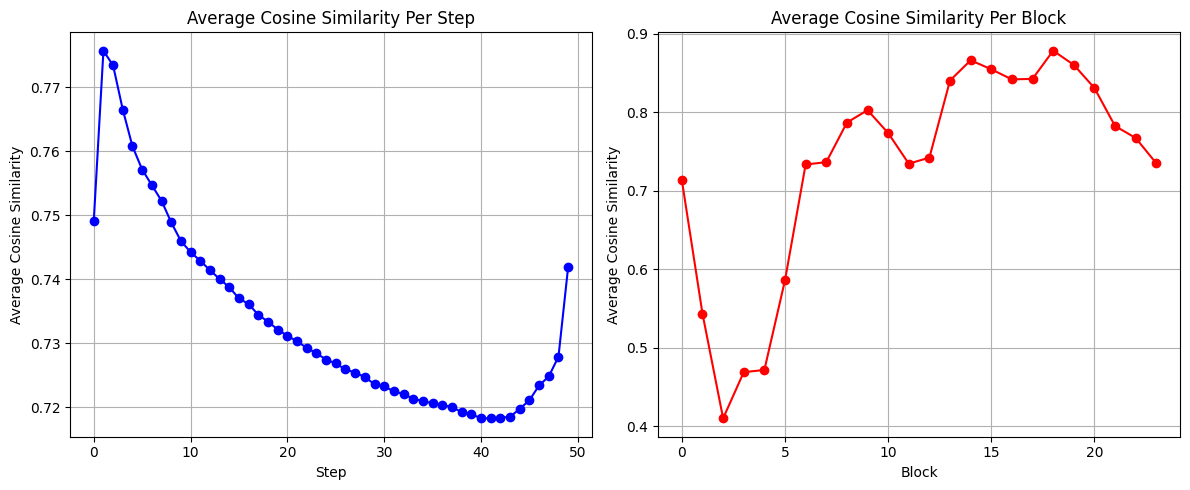

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read_and_reshape_data(file_path, steps=50, blocks_per_step=24):
    # 从文件中读取数据
    with open(file_path, 'r') as file:
        similarities = np.array([float(line.strip()) for line in file if line.strip()])

    # 将数据重组成[steps, blocks_per_step]的形式
    reshaped_data = similarities.reshape(steps, blocks_per_step)
    
    # 计算每个step的平均相似度
    average_per_step = reshaped_data.mean(axis=1)
    
    # 计算每个block的平均相似度
    average_per_block = reshaped_data.mean(axis=0)
    
    return average_per_step, average_per_block

def plot_data(average_per_step, average_per_block):
    # 创建图表，两个子图
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # 绘制基于Step的平均相似度变化
    steps = np.arange(len(average_per_step))
    axes[0].plot(steps, average_per_step, marker='o', linestyle='-', color='b')
    axes[0].set_title('Average Cosine Similarity Per Step')
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('Average Cosine Similarity')
    axes[0].grid(True)

    # 绘制基于Block的平均相似度变化
    blocks = np.arange(len(average_per_block))
    axes[1].plot(blocks, average_per_block, marker='o', linestyle='-', color='r')
    axes[1].set_title('Average Cosine Similarity Per Block')
    axes[1].set_xlabel('Block')
    axes[1].set_ylabel('Average Cosine Similarity')
    axes[1].grid(True)

    # 显示图表
    plt.tight_layout()
    plt.show()

# 文件路径
file_path = "average_cosine_similarity.txt"

# 读取和重组数据
average_per_step, average_per_block = read_and_reshape_data(file_path)

# 绘制数据
plot_data(average_per_step, average_per_block)